In [1]:
!nvidia-smi

Thu Jun 17 04:45:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arkaprabhabasu","key":"d857845316d9b5d6aa8d4ea442e1f607"}'}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:38<00:00, 69.6MB/s]
100% 2.29G/2.29G [00:38<00:00, 63.6MB/s]


In [ ]:
!unzip "/content/chest-xray-pneumonia.zip"

In [10]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path=Path("/content/chest_xray")

In [12]:
data = ImageDataBunch.from_folder(path, train='train', valid='test', ds_tfms=get_transforms(do_flip=False), size=224, bs=64, num_workers=8)

['NORMAL', 'PNEUMONIA'] 2
5216 624


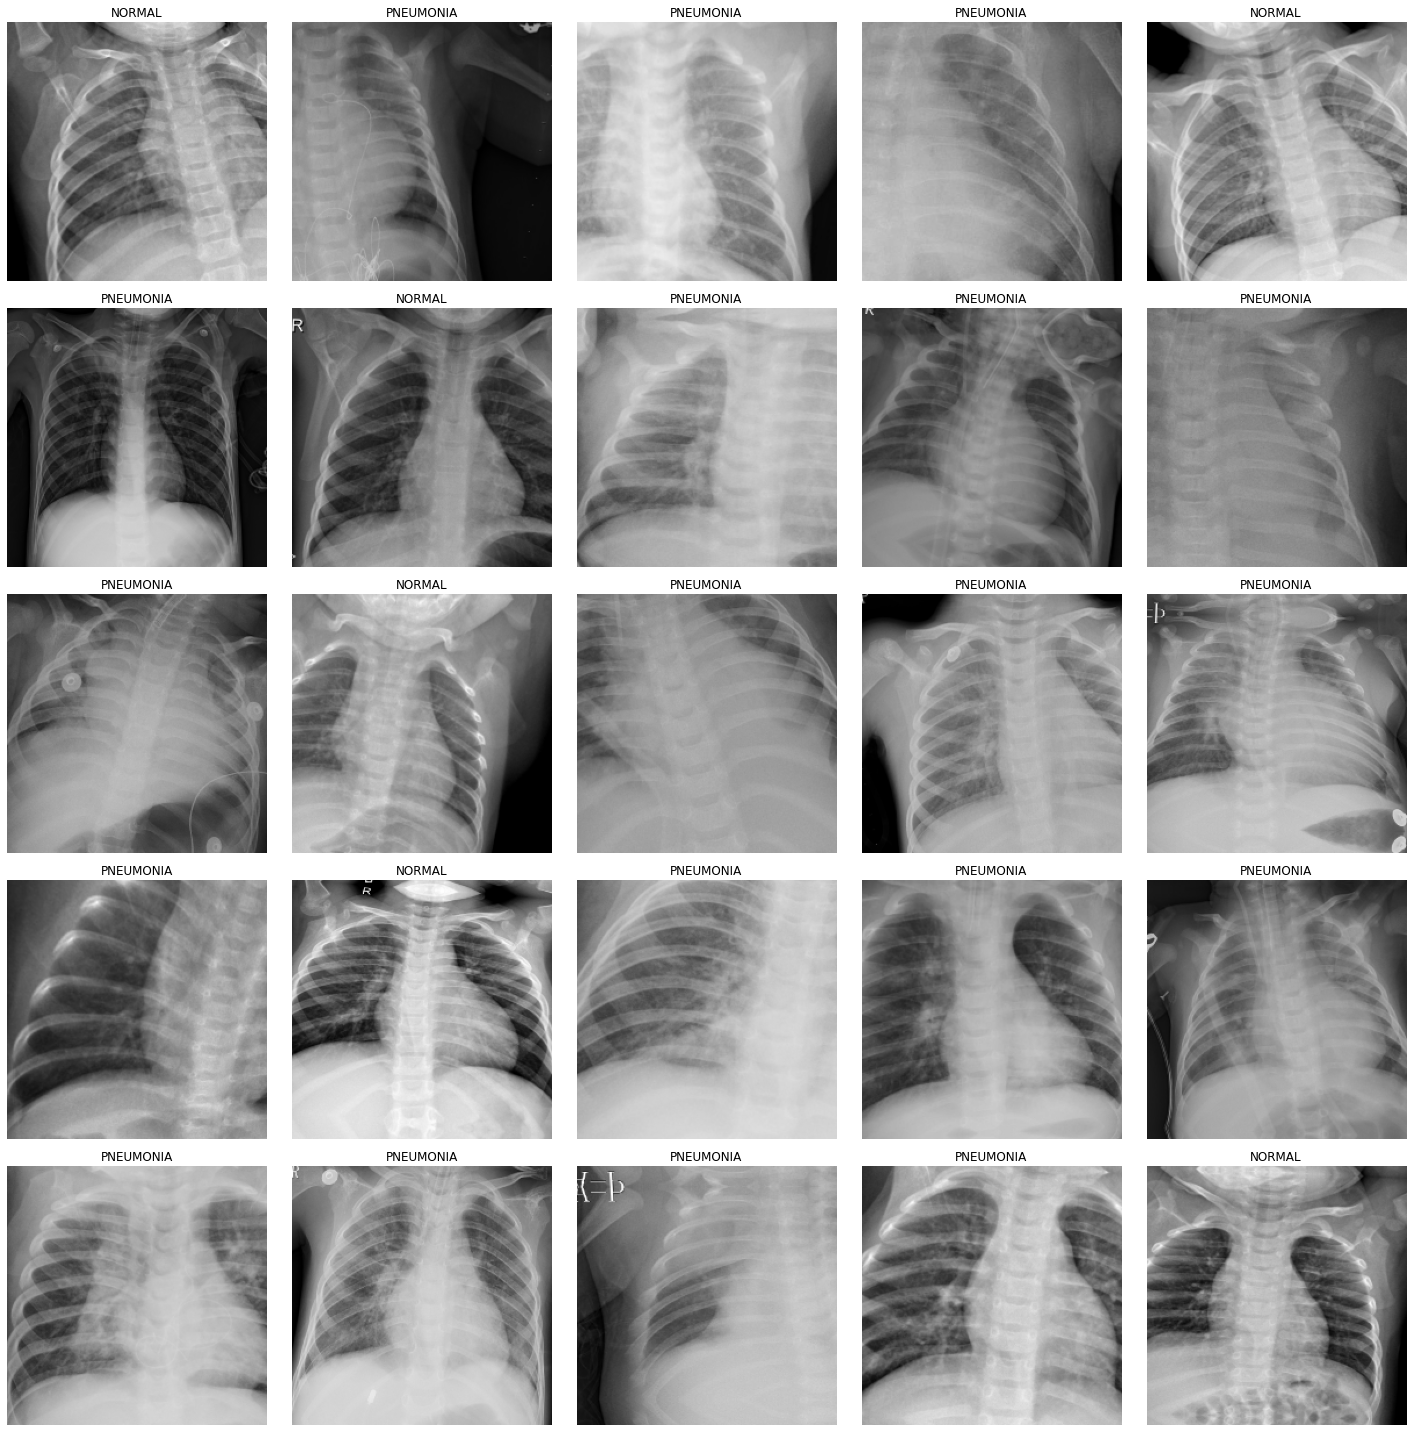

In [13]:
data.show_batch()
# See the classes and count of classes in your dataset
print(data.classes,data.c)
print(len(data.train_ds), len(data.valid_ds))

In [14]:
learn = cnn_learner(data, models.resnet50, metrics = [accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [15]:
learn.fit_one_cycle(25)

epoch,train_loss,valid_loss,accuracy,time
0,0.450732,0.543561,0.844551,02:00
1,0.325698,0.557493,0.875000,02:00
2,0.270404,0.500161,0.862179,01:59
3,0.215216,0.403502,0.862179,01:59
4,0.164800,0.465009,0.873397,02:01
5,0.144303,0.364848,0.886218,02:00
6,0.132295,0.468205,0.876603,02:01
7,0.118962,0.261226,0.902244,01:59
8,0.100360,0.401179,0.895833,02:00
9,0.101241,0.371505,0.887821,01:59


In [16]:
#data_path=Path('./chest_xray').absolute()
model_path=Path('/content/drive/MyDrive').absolute()

In [17]:
learn.export(model_path / 'export.pkl')
learn.save(model_path / 'export')

In [34]:
! cp "/content/drive/MyDrive/export.pkl" drive/"My Drive"/

cp: '/content/drive/MyDrive/export.pkl' and 'drive/My Drive/export.pkl' are the same file


In [ ]:
# Save the model
learn.save('stage-1')

# Load the Model
learn.load('stage-1')

In [19]:
# Build a Classification Interpretation object from our learn model
interp = ClassificationInterpretation.from_learner(learn)

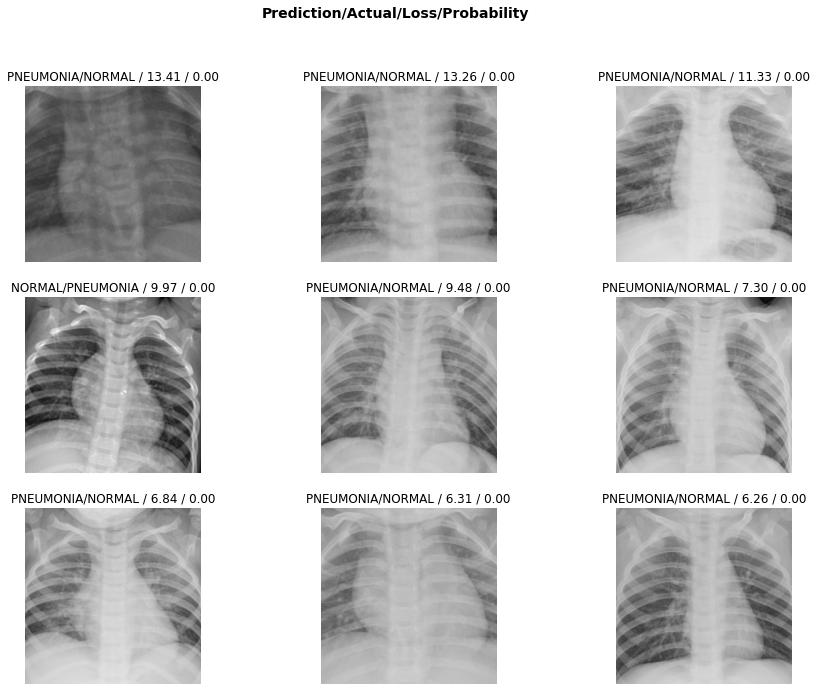

In [22]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

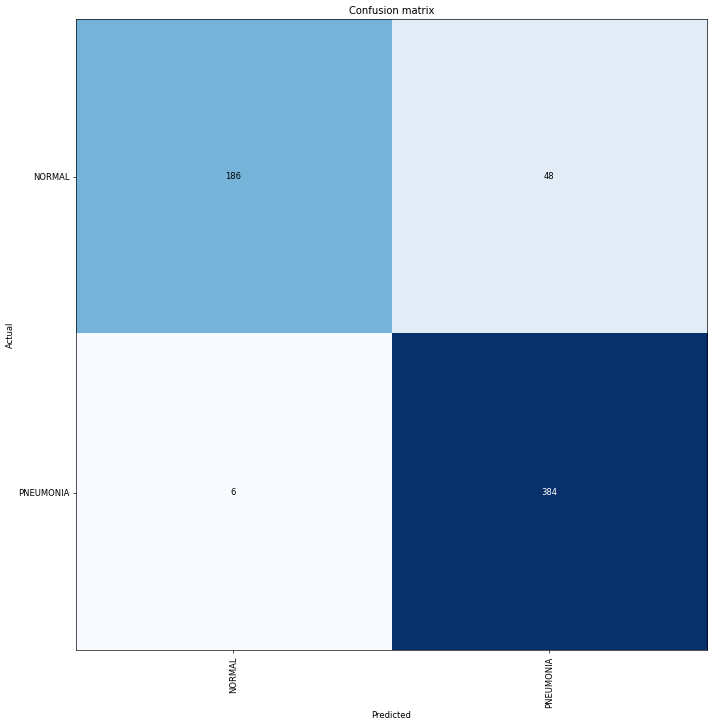

In [21]:
# Build a confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
# Build a text version of a confusion matrix-- really helpful with a lot of classes
interp.most_confused(min_val=2)

[('NORMAL', 'PNEUMONIA', 48), ('PNEUMONIA', 'NORMAL', 6)]

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.74E-06


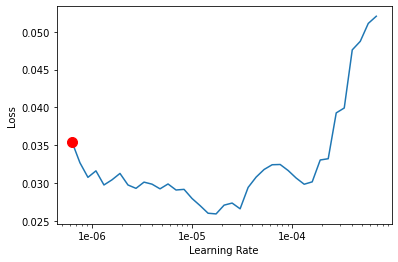

In [24]:
learn.unfreeze()

# Find the optimal learning rate and plot a visual
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [25]:
# Fit the model over 2 epochs
learn.fit_one_cycle(2, max_lr=slice(3e-7, 3e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.041624,0.390765,0.902244,02:00
1,0.041103,0.379341,0.902244,02:00


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 9.12E-08


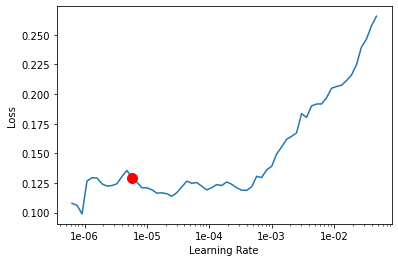

In [34]:
# See if optimal learning rate changes
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
# Fit the model 2 more epochs over all the layers
learn.fit_one_cycle(25, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.049905,0.347199,0.910256,02:01
1,0.053220,0.506345,0.878205,02:00
2,0.059366,0.276144,0.923077,02:00
3,0.068987,0.662016,0.812500,02:00
4,0.060154,0.699357,0.807692,02:00
5,0.060242,0.273210,0.926282,02:00
6,0.057798,0.273012,0.926282,02:00
7,0.057765,0.409013,0.870192,02:00
8,0.047618,0.300596,0.911859,02:01
9,0.060049,0.368419,0.902244,02:01


In [27]:
# Save the model
learn.save('stage-2')

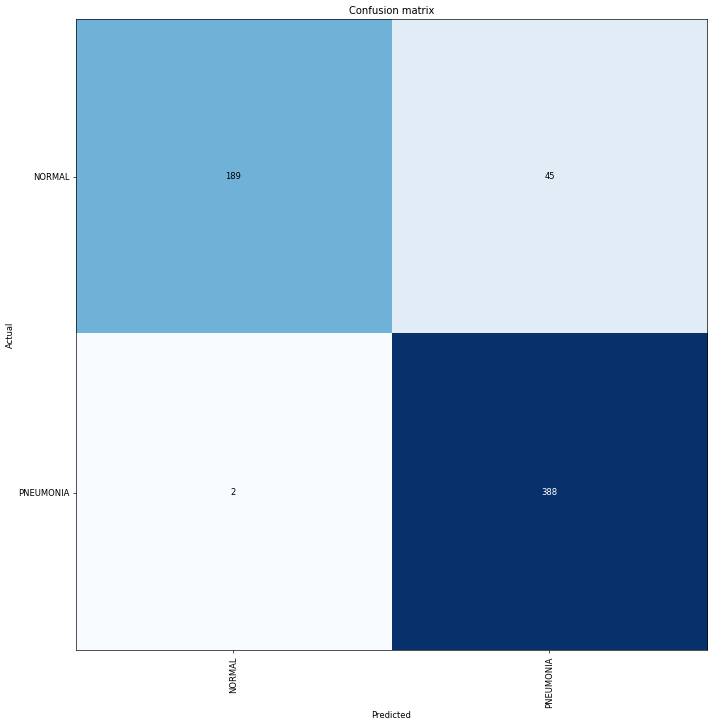

In [28]:
# Rebuild interpreter and replot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [29]:
# Save final stage of model
learn.save('stage-2')

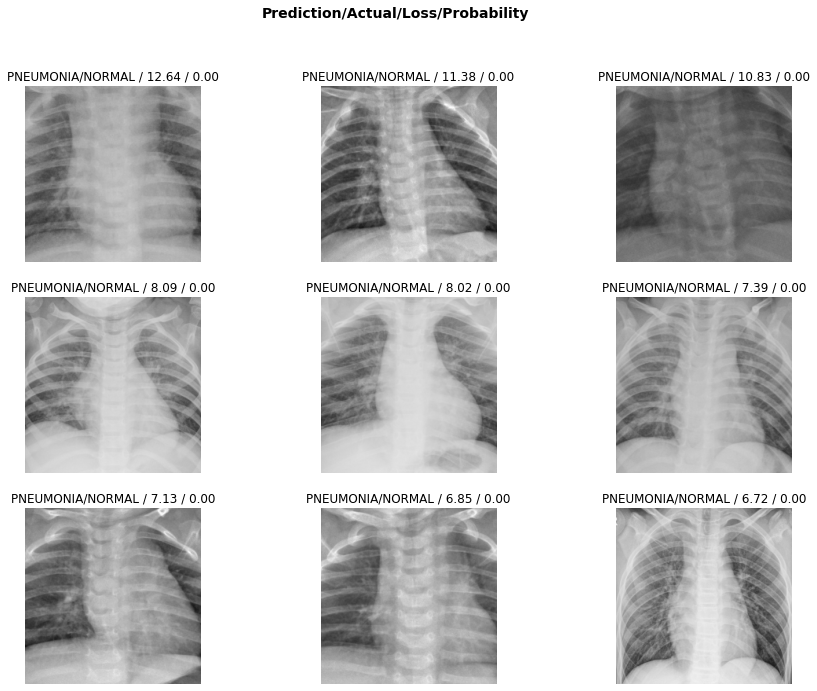

In [30]:
# Show top 9 images with the highest loss
interp.plot_top_losses(9, figsize=(15,11))

In [31]:
# Build a text version of a confusion matrix-- really helpful with a lot of classes
interp.most_confused(min_val=2)

[('NORMAL', 'PNEUMONIA', 45), ('PNEUMONIA', 'NORMAL', 2)]

In [33]:
print(model_path)
learn.export(model_path / 'export.pkl')
learn.save(model_path / 'pneumonia')

/content/drive/MyDrive


In [34]:
from fastai.callbacks.hooks import *

In [35]:
#learn=load_learner("..")
learn=load_learner("/content/drive/MyDrive")
model=learn.model.eval()

In [42]:
img=open_image("/content/C15sharpClaheG15Normal-3.png")

In [43]:
pred=learn.predict(img)
cls=int(pred[1])
pred,cls

((Category tensor(0), tensor(0), tensor([0.5034, 0.4966])), 0)

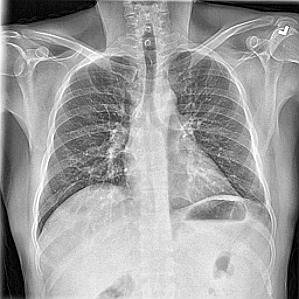

In [44]:
b, _ =learn.data.one_item(img,denorm=False)
#b = Image(data.one_item(img,denorm=True))
#b=b.cuda()
img

In [46]:
with hook_output(model[0]) as hook_a:
  with hook_output(model[0],grad=True) as hook_g:
    preds=model(b)
    preds[0,cls].backward()
acts=hook_a.stored[0].cpu()
grad=hook_g.stored[0][0].cpu()

In [47]:
grad_chan=grad.mean(1).mean(1)
mult=((acts*grad_chan[..., None, None])).sum(0)

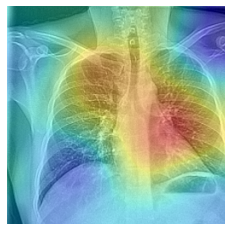

In [48]:
_, ax=plt.subplots()
img.show(ax)
ax.imshow(mult, alpha=0.4, extent=(0,256,256,0), interpolation='bicubic', cmap='jet')